<h1>LSTM AutoEncoder Prototype</h1>
We will try to build a pipeline for this, so that we may feed all 9 tags into training and validation.

In [1]:
#importing libraries and dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import tensorflow as tf
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import LSTM,Input,Dropout

In [2]:
#load the dataframe
df19=pd.read_excel('OracleTags2.xlsx',sheet_name='Feed19')
dfP=pd.read_excel('OracleTags2.xlsx',sheet_name='SysP')
dfA1=pd.read_excel('OracleTags2.xlsx',sheet_name='ART1')
dfA2=pd.read_excel('OracleTags2.xlsx',sheet_name='ART2')
dfA3=pd.read_excel('OracleTags2.xlsx',sheet_name='ART3')
dfp1a=pd.read_excel('OracleTags2.xlsx',sheet_name='DisP1A')
dfp1b=pd.read_excel('OracleTags2.xlsx',sheet_name='DisP1B')
dfk1a=pd.read_excel('OracleTags2.xlsx',sheet_name='K1ATemp')
dfk1b=pd.read_excel('OracleTags2.xlsx',sheet_name='K1BTemp')

df19.info()
dfP.info()
dfA1.info()
dfA2.info()
dfA3.info()
dfp1a.info()
dfp1b.info()
dfk1a.info()
dfk1b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525601 entries, 0 to 525600
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    525601 non-null  datetime64[ns]
 1   Feed19  525601 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 8.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525601 entries, 0 to 525600
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    525601 non-null  datetime64[ns]
 1   SysP    525601 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 8.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525601 entries, 0 to 525600
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    525601 non-null  datetime64[ns]
 1   ART1    525601 non-null  object        
dtypes: date

In [3]:
#alright, let's change the data type
def change_types(df):
    for col in df.columns:
        if df[col].dtypes == 'object':
            df[col] = df[col].apply(pd.to_numeric,errors ='coerce')
    return df

#change all the datatypes
df19 = change_types(df19)
dfP = change_types(dfP)
dfA1 = change_types(dfA1)
dfA2 = change_types(dfA2)
dfA3 = change_types(dfA3)
dfp1a = change_types(dfp1a)
dfp1b = change_types(dfp1b)
dfk1a = change_types(dfk1a)
dfk1b = change_types(dfk1b)

#forward fill the missing data
df19 = df19.fillna(0)
dfP = dfP.fillna(0)
dfA1 = dfA1.fillna(0)
dfA2 = dfA2.fillna(0)
dfA3 = dfA3.fillna(0)
dfp1a = dfp1a.fillna(0)
dfp1b = dfp1b.fillna(0)
dfk1a = dfk1a.fillna(0)
dfk1b = dfk1b.fillna(0)

#print all the results
df19.info()
dfP.info()
dfA1.info()
dfA2.info()
dfA3.info()
dfp1a.info()
dfp1b.info()
dfk1a.info()
dfk1b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525601 entries, 0 to 525600
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    525601 non-null  datetime64[ns]
 1   Feed19  525601 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525601 entries, 0 to 525600
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    525601 non-null  datetime64[ns]
 1   SysP    525601 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525601 entries, 0 to 525600
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    525601 non-null  datetime64[ns]
 1   ART1    525601 non-null  float64       
dtypes: date

<h2>Splitting Normal and Anomaly Trend</h2>
We try to split every dataframe with anomaly and normal trend
Let's do this for process trend first, then we will comeback to equipment trend.

In [4]:
#let's add month columns to all our dataframes

df19['month'] = df19['Date'].dt.month
dfP['month'] = dfP['Date'].dt.month
dfA1['month'] = dfA1['Date'].dt.month
dfA2['month'] = dfA2['Date'].dt.month
dfA3['month'] = dfA3['Date'].dt.month
dfp1a['month'] = dfp1a['Date'].dt.month
dfp1b['month'] = dfp1b['Date'].dt.month
dfk1a['month'] = dfk1a['Date'].dt.month
dfk1b['month'] = dfk1b['Date'].dt.month


#separate the normal and anomaly months
#feed 19
dfn19= df19.loc[df19['month']<3]
dfa19= df19.loc[df19['month']==4]
dft19 = df19.loc[df19['month']>5]

#sysp
dfnP= dfP.loc[dfP['month']<3]
dfaP= dfP.loc[dfP['month']==4]
dftP= dfP.loc[dfP['month']>5]

#ART1
dfnA1= dfA1.loc[dfA1['month']<3]
dfaA1= dfA1.loc[dfA1['month']==4]
dftA1= dfA1.loc[dfA1['month']>5]

#ART2
dfnA2=dfA2.loc[dfA2['month']<3]
dfaA2=dfA2.loc[dfA2['month']==4]
dftA2=dfA2.loc[dfA2['month']<5]

#ART3
dfnA3=dfA3.loc[dfA3['month']<3]
dfaA3=dfA3.loc[dfA3['month']==4]
dftA3=dfA3.loc[dfA3['month']>5]

In [5]:
#let's scaled the data first
scaler=MinMaxScaler()


#scaled all the data
#feed 19
df19['Feed19']=scaler.fit_transform(df19[['Feed19']])
dfn19['Feed19']=scaler.fit_transform(dfn19[['Feed19']])
dfa19['Feed19']=scaler.fit_transform(dfa19[['Feed19']])
dft19['Feed19']=scaler.fit_transform(dft19[['Feed19']])

#sys pressure
dfP['SysP']=scaler.fit_transform(dfP[['SysP']])
dfnP['SysP']=scaler.fit_transform(dfnP[['SysP']])
dfaP['SysP']=scaler.fit_transform(dfaP[['SysP']])
dftP['SysP']=scaler.fit_transform(dftP[['SysP']])

#ART1
dfA1['ART1']=scaler.fit_transform(dfA1[['ART1']])
dfnA1['ART1']=scaler.fit_transform(dfnA1[['ART1']])
dfaA1['ART1']=scaler.fit_transform(dfaA1[['ART1']])
dftA1['ART1']=scaler.fit_transform(dftA1[['ART1']])

#ART2
dfA2['ART2']=scaler.fit_transform(dfA2[['ART2']])
dfnA2['ART2']=scaler.fit_transform(dfnA2[['ART2']])
dfaA2['ART2']=scaler.fit_transform(dfaA2[['ART2']])
dftA2['ART2']=scaler.fit_transform(dftA2[['ART2']])

#ART3
dfA3['ART3']=scaler.fit_transform(dfA3[['ART3']])
dfnA3['ART3']=scaler.fit_transform(dfnA3[['ART3']])
dfaA3['ART3']=scaler.fit_transform(dfaA3[['ART3']])
dftA3['ART3']=scaler.fit_transform(dftA3[['ART3']])

/var/folders/v4/jpplyq9d7vj4bb3_yglz32000000gn/T/ipykernel_32838/4257690859.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn19['Feed19']=scaler.fit_transform(dfn19[['Feed19']])
/var/folders/v4/jpplyq9d7vj4bb3_yglz32000000gn/T/ipykernel_32838/4257690859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfa19['Feed19']=scaler.fit_transform(dfa19[['Feed19']])
/var/folders/v4/jpplyq9d7vj4bb3_yglz32000000gn/T/ipykernel_32838/4257690859.py:10: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [6]:
#reset the index
#feed 19
df19 = df19.reset_index(drop=True)
dfn19= dfn19.reset_index(drop=True)
dfa19= dfa19.reset_index(drop=True)
dft19 = dft19.reset_index(drop=True)

#sysp
dfP=dfP.reset_index(drop=True)
dfnP= dfnP.reset_index(drop=True)
dfaP= dfaP.reset_index(drop=True)
dftP= dftP.reset_index(drop=True)

#ART1
dfA1=dfA1.reset_index(drop=True)
dfnA1=dfnA1.reset_index(drop=True)
dfaA1=dfaA1.reset_index(drop=True)
dftA1=dftA1.reset_index(drop=True)

#ART2
dfA2=dfA2.reset_index(drop=True)
dfnA2=dfnA2.reset_index(drop=True)
dfaA2=dfaA2.reset_index(drop=True)
dftA2=dftA2.reset_index(drop=True)


#ART3
dfA3=dfA3.reset_index(drop=True)
dfnA3=dfnA3.reset_index(drop=True)
dfaA3=dfaA3.reset_index(drop=True)
dftA3=dftA3.reset_index(drop=True)

In [7]:
#defining sequence functions build

seq_size=60


def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        #print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values), np.array(y_values)

In [8]:
#split for training and testing data
#feed19
X19_train,y19_train=to_sequences(dfn19[['Feed19']],dfn19[['Feed19']],seq_size)
X19_test,y19_test=to_sequences(dfa19[['Feed19']],dfa19[['Feed19']],seq_size)

#sysP
XP_train,yP_train=to_sequences(dfnP[['SysP']],dfnP[['SysP']],seq_size)
XP_test,yP_test=to_sequences(dftP[['SysP']],dftP[['SysP']],seq_size)

#ART1
X1_train,y1_train=to_sequences(dfnA1[['ART1']],dfnA1[['ART1']],seq_size)
X1_test,y1_test=to_sequences(dftA1[['ART1']],dftA1[['ART1']],seq_size)


#ART2
X2_train,y2_train=to_sequences(dfnA2[['ART2']],dfnA2[['ART2']],seq_size)
X2_test,y2_test=to_sequences(dftA2[['ART2']],dftA2[['ART2']],seq_size)

#ART3
X3_train,y3_train=to_sequences(dfnA3[['ART3']],dfnA3[['ART3']],seq_size)
X3_test,y3_test=to_sequences(dftA3[['ART3']],dftA3[['ART3']],seq_size)

print(X19_train.shape)
print(y19_train.shape)
print(X19_test.shape)
print(y19_test.shape)

print(XP_train.shape)
print(yP_train.shape)
print(XP_test.shape)
print(yP_test.shape)

(84901, 60, 1)
(84901, 1)
(43140, 60, 1)
(43140, 1)
(84901, 60, 1)
(84901, 1)
(308100, 60, 1)
(308100, 1)


Seems like everything is now ready, let's build our neural network


In [9]:
import json
import numpy as np



# Convert the numpy array to a Python list
python_list = X19_test.tolist()

# Convert the Python list to a JSON-formatted string
json_string = json.dumps(python_list)

# Print the JSON-formatted string
print(json_string)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<h2>LSTM Neural Network</h2>
Let's build our model using LSTM Sequential model with Keras and Tensorflow

In [10]:
#first model for Feed19
model19=Sequential()
model19.add(LSTM(128,input_shape=(X19_train.shape[1],X19_train.shape[2])))
model19.add(Dropout(rate=0.2))

model19.add(RepeatVector(X19_train.shape[1]))

model19.add(LSTM(128,return_sequences=True))
model19.add(Dropout(rate=0.2))
model19.add(TimeDistributed(Dense(X19_train.shape[2])))
model19.compile(optimizer='adam',loss='mae')

#2nd model for Sys Pressure
modelP=Sequential()
modelP.add(LSTM(128,input_shape=(XP_train.shape[1],XP_train.shape[2])))
modelP.add(Dropout(rate=0.2))

modelP.add(RepeatVector(XP_train.shape[1]))

modelP.add(LSTM(128,return_sequences=True))
modelP.add(Dropout(rate=0.2))
modelP.add(TimeDistributed(Dense(XP_train.shape[2])))
modelP.compile(optimizer='adam',loss='mae')


#3rd model for ART1
model1=Sequential()
model1.add(LSTM(128,input_shape=(X1_train.shape[1],X1_train.shape[2])))
model1.add(Dropout(rate=0.2))

model1.add(RepeatVector(X1_train.shape[1]))

model1.add(LSTM(128,return_sequences=True))
model1.add(Dropout(rate=0.2))
model1.add(TimeDistributed(Dense(X1_train.shape[2])))
model1.compile(optimizer='adam',loss='mae')


#4th moodel for ART2
model2=Sequential()
model2.add(LSTM(128,input_shape=(X2_train.shape[1],X2_train.shape[2])))
model2.add(Dropout(rate=0.2))

model2.add(RepeatVector(X2_train.shape[1]))

model2.add(LSTM(128,return_sequences=True))
model2.add(Dropout(rate=0.2))
model2.add(TimeDistributed(Dense(X2_train.shape[2])))
model2.compile(optimizer='adam',loss='mae')


#5th model for ART3
model3=Sequential()
model3.add(LSTM(128,input_shape=(X3_train.shape[1],X3_train.shape[2])))
model3.add(Dropout(rate=0.2))

model3.add(RepeatVector(X3_train.shape[1]))

model3.add(LSTM(128,return_sequences=True))
model3.add(Dropout(rate=0.2))
model3.add(TimeDistributed(Dense(X3_train.shape[2])))
model3.compile(optimizer='adam',loss='mae')

<h3>Let's fit and train the first model</h3>

In [11]:
#time to fit the model 
history19 = model19.fit(X19_train, y19_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)

Epoch 1/10
1194/1194 [==============================] - 92s 76ms/step - loss: 0.0389 - val_loss: 0.0017
Epoch 2/10
1194/1194 [==============================] - 93s 78ms/step - loss: 0.0213 - val_loss: 0.0011
Epoch 3/10
1194/1194 [==============================] - 90s 76ms/step - loss: 0.0130 - val_loss: 0.0011
Epoch 4/10
1194/1194 [==============================] - 89s 74ms/step - loss: 0.0081 - val_loss: 0.0026
Epoch 5/10
1194/1194 [==============================] - 88s 74ms/step - loss: 0.0070 - val_loss: 0.0012
Epoch 6/10
1194/1194 [==============================] - 89s 75ms/step - loss: 0.0060 - val_loss: 0.0019
Epoch 7/10
1194/1194 [==============================] - 100s 84ms/step - loss: 0.0059 - val_loss: 0.0026
Epoch 8/10
1194/1194 [==============================] - 105s 88ms/step - loss: 0.0056 - val_loss: 0.0010
Epoch 9/10
1194/1194 [==============================] - 90s 76ms/step - loss: 0.0056 - val_loss: 0.0021
Epoch 10/10
1194/1194 [==============================] - 99s 8

In [12]:
#the 2nd model
historyP = modelP.fit(XP_train, yP_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)

Epoch 1/10
1194/1194 [==============================] - 95s 79ms/step - loss: 0.0409 - val_loss: 9.8635e-04
Epoch 2/10
1194/1194 [==============================] - 93s 78ms/step - loss: 0.0203 - val_loss: 0.0034
Epoch 3/10
1194/1194 [==============================] - 94s 78ms/step - loss: 0.0068 - val_loss: 0.0018
Epoch 4/10
1194/1194 [==============================] - 94s 79ms/step - loss: 0.0013 - val_loss: 6.4459e-04
Epoch 5/10
1194/1194 [==============================] - 94s 79ms/step - loss: 8.5167e-04 - val_loss: 6.4101e-04
Epoch 6/10
1194/1194 [==============================] - 94s 78ms/step - loss: 8.4095e-04 - val_loss: 7.2801e-04
Epoch 7/10
1194/1194 [==============================] - 94s 78ms/step - loss: 8.4486e-04 - val_loss: 6.4135e-04
Epoch 8/10
1194/1194 [==============================] - 95s 80ms/step - loss: 8.4867e-04 - val_loss: 6.4782e-04
Epoch 9/10
1194/1194 [==============================] - 94s 79ms/step - loss: 8.4727e-04 - val_loss: 7.4566e-04
Epoch 10/10
1194

In [13]:
#the third model
history1 = model1.fit(X1_train, y1_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)

Epoch 1/10
1194/1194 [==============================] - 95s 79ms/step - loss: 0.0402 - val_loss: 0.0111
Epoch 2/10
1194/1194 [==============================] - 94s 79ms/step - loss: 0.0241 - val_loss: 0.0073
Epoch 3/10
1194/1194 [==============================] - 95s 79ms/step - loss: 0.0162 - val_loss: 0.0029
Epoch 4/10
1194/1194 [==============================] - 95s 80ms/step - loss: 0.0088 - val_loss: 0.0040
Epoch 5/10
1194/1194 [==============================] - 95s 79ms/step - loss: 0.0043 - val_loss: 0.0025
Epoch 6/10
1194/1194 [==============================] - 95s 80ms/step - loss: 0.0028 - val_loss: 0.0049
Epoch 7/10
1194/1194 [==============================] - 95s 80ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 8/10
1194/1194 [==============================] - 94s 79ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 9/10
1194/1194 [==============================] - 105s 88ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 10/10
1194/1194 [==============================] - 113s 9

In [14]:
#the fourth model
history2 = model2.fit(X2_train, y2_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)

Epoch 1/10
1194/1194 [==============================] - 104s 86ms/step - loss: 0.0395 - val_loss: 0.0055
Epoch 2/10
1194/1194 [==============================] - 97s 81ms/step - loss: 0.0228 - val_loss: 0.0065
Epoch 3/10
1194/1194 [==============================] - 93s 78ms/step - loss: 0.0141 - val_loss: 0.0044
Epoch 4/10
1194/1194 [==============================] - 92s 77ms/step - loss: 0.0081 - val_loss: 0.0050
Epoch 5/10
1194/1194 [==============================] - 92s 77ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 6/10
1194/1194 [==============================] - 92s 77ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 7/10
1194/1194 [==============================] - 92s 77ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 8/10
1194/1194 [==============================] - 91s 76ms/step - loss: 0.0025 - val_loss: 2.7111e-04
Epoch 9/10
1194/1194 [==============================] - 92s 77ms/step - loss: 0.0022 - val_loss: 3.1385e-04
Epoch 10/10
1194/1194 [==============================] 

In [15]:
#the fifth model
history3 = model3.fit(X3_train, y3_train, epochs=40, batch_size=64, validation_split=0.1, verbose=1)

Epoch 1/40
1194/1194 [==============================] - 95s 79ms/step - loss: 0.0392 - val_loss: 0.0125
Epoch 2/40
1194/1194 [==============================] - 92s 77ms/step - loss: 0.0210 - val_loss: 0.0086
Epoch 3/40
1194/1194 [==============================] - 92s 77ms/step - loss: 0.0107 - val_loss: 0.0060
Epoch 4/40
1194/1194 [==============================] - 91s 76ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 5/40
1194/1194 [==============================] - 91s 76ms/step - loss: 0.0053 - val_loss: 0.0033
Epoch 6/40
1194/1194 [==============================] - 91s 76ms/step - loss: 0.0047 - val_loss: 0.0011
Epoch 7/40
1194/1194 [==============================] - 91s 76ms/step - loss: 0.0039 - val_loss: 0.0102
Epoch 8/40
1194/1194 [==============================] - 93s 78ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 9/40
1194/1194 [==============================] - 94s 78ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 10/40
1194/1194 [==============================] - 93s 78m

In [16]:
#save the model
model19.save('Feed19model/')
modelP.save('SysPmodel/')
model1.save('ART1model/')
model2.save('ART2model/')
model3.save('ART3model/')

INFO:tensorflow:Assets written to: Feed19model/assets


INFO:tensorflow:Assets written to: Feed19model/assets


INFO:tensorflow:Assets written to: SysPmodel/assets


INFO:tensorflow:Assets written to: SysPmodel/assets


INFO:tensorflow:Assets written to: ART1model/assets


INFO:tensorflow:Assets written to: ART1model/assets


INFO:tensorflow:Assets written to: ART2model/assets


INFO:tensorflow:Assets written to: ART2model/assets


INFO:tensorflow:Assets written to: ART3model/assets


INFO:tensorflow:Assets written to: ART3model/assets


In [17]:
#save the MAE for all model

#mae feed 19
pred19=model19.predict(X19_test)
mae19=np.mean(np.abs(pred19-X19_test),axis=1)

#mae system pressure
predP=modelP.predict(XP_test)
maeP=np.mean(np.abs(predP-XP_test),axis=1)

#mae ART1
pred1=model1.predict(X1_test)
mae1=np.mean(np.abs(pred1-X1_test),axis=1)

#mae ART2
pred2=model2.predict(X2_test)
mae2=np.mean(np.abs(pred2-X2_test),axis=1)

#mae ART3
pred3=model3.predict(X3_test)
mae3=np.mean(np.abs(pred3-X3_test),axis=1)

9629/9629 [==============================] - 135s 14ms/step


In [18]:
#let's save the mae for the anomaly data
#feed 19
Xa19_test,ya19_test=to_sequences(dfa19[['Feed19']],dfa19[['Feed19']],seq_size)

#sys pressure
XaP_test,yaP_test=to_sequences(dfaP[['SysP']],dfaP[['SysP']],seq_size)

#ART1

Xa1_test,ya1_test=to_sequences(dfaA1[['ART1']],dfaA1[['ART1']],seq_size)

#ART2

Xa2_test,ya2_test=to_sequences(dfaA2[['ART2']],dfaA2[['ART2']],seq_size)

#ART3
Xa3_test,ya3_test=to_sequences(dfaA3[['ART3']],dfaA3[['ART3']],seq_size)


#save the MAE for anomaly data
#mae feed 19
preda19=model19.predict(Xa19_test)
maea19=np.std(np.abs(preda19-Xa19_test),axis=1)

#mae system pressure
predaP=modelP.predict(XaP_test)
maeaP=np.mean(np.abs(predaP-XaP_test),axis=1)

#mae ART1
preda1=model1.predict(Xa1_test)
maea1=np.mean(np.abs(preda1-Xa1_test),axis=1)

#mae ART2
preda2=model2.predict(Xa2_test)
maea2=np.mean(np.abs(preda2-Xa2_test),axis=1)

#mae ART3
preda3=model3.predict(Xa3_test)
maea3=np.mean(np.abs(preda3-Xa3_test),axis=1)

1349/1349 [==============================] - 20s 15ms/step


Text(0.5, 1.0, 'Anomaly Dectection Graph for Feed 19')

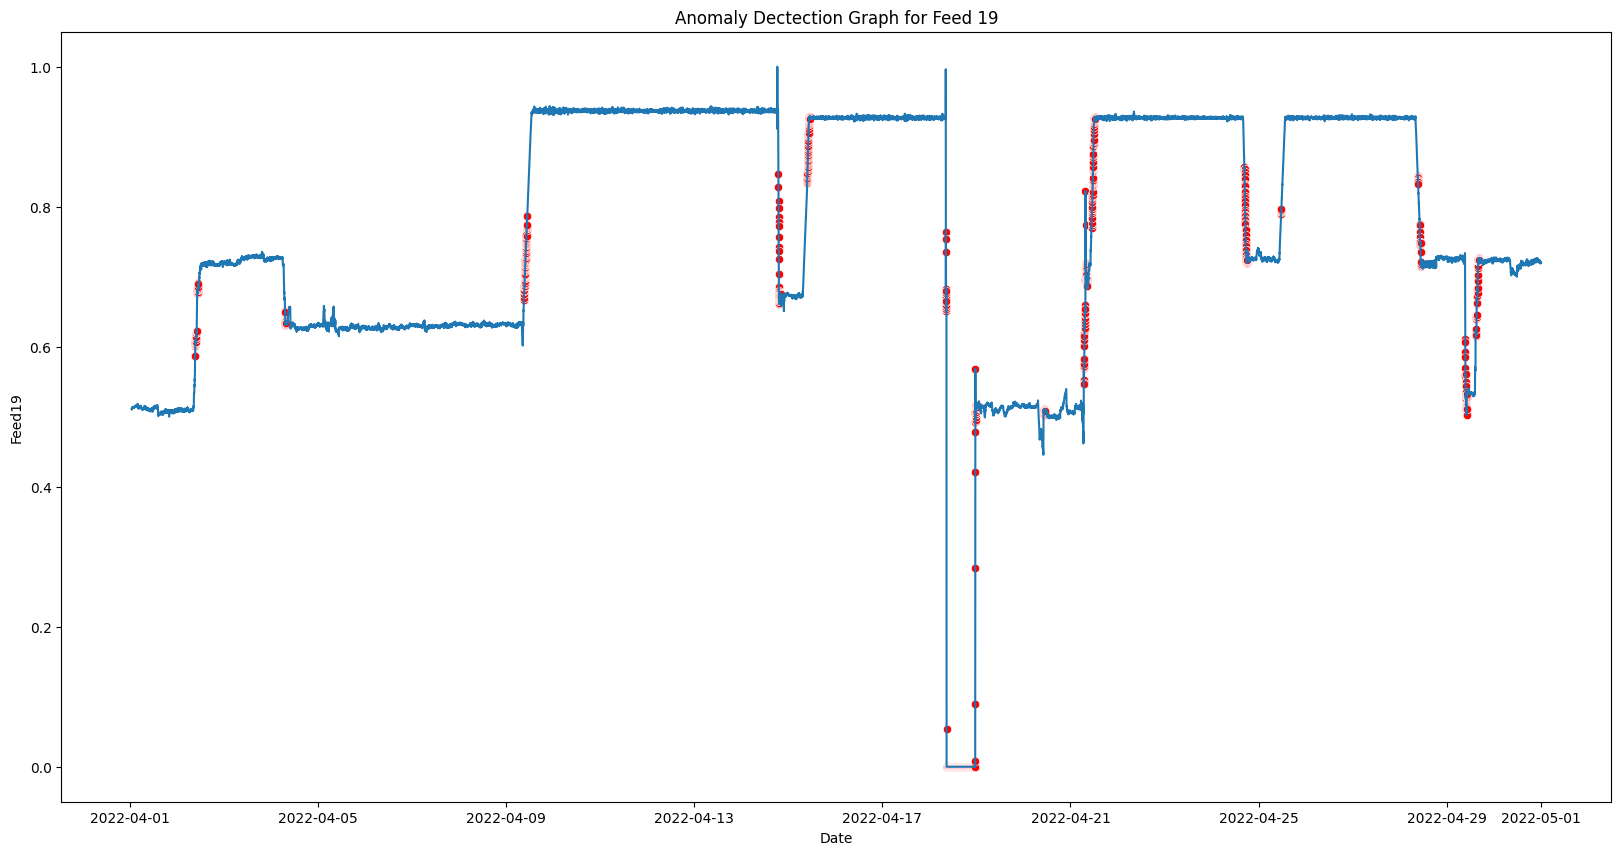

In [19]:
#let's plot the anomaly on the plot


#feed19
dfanomaly19=pd.DataFrame(dfa19[seq_size:])
dfanomaly19['Atest_MAE']=maea19
dfanomaly19['max_MAE']=np.mean(maea19)*3
dfanomaly19['anomaly']=dfanomaly19['Atest_MAE']>dfanomaly19['max_MAE']
dfa19['Feed19']=dfa19[seq_size:]['Feed19']

anomalies19=dfanomaly19.loc[dfanomaly19['anomaly']==True]

plt.figure(figsize=(20,10))

#plot anomalies and current data
sns.lineplot(x=dfanomaly19['Date'],y=dfanomaly19['Feed19'])
sns.scatterplot(x=dfanomaly19['Date'],y=anomalies19['Feed19'],color='r')

plt.title('Anomaly Dectection Graph for Feed 19')

Text(0.5, 1.0, 'Anomaly Dectection Graph for System Pressure')

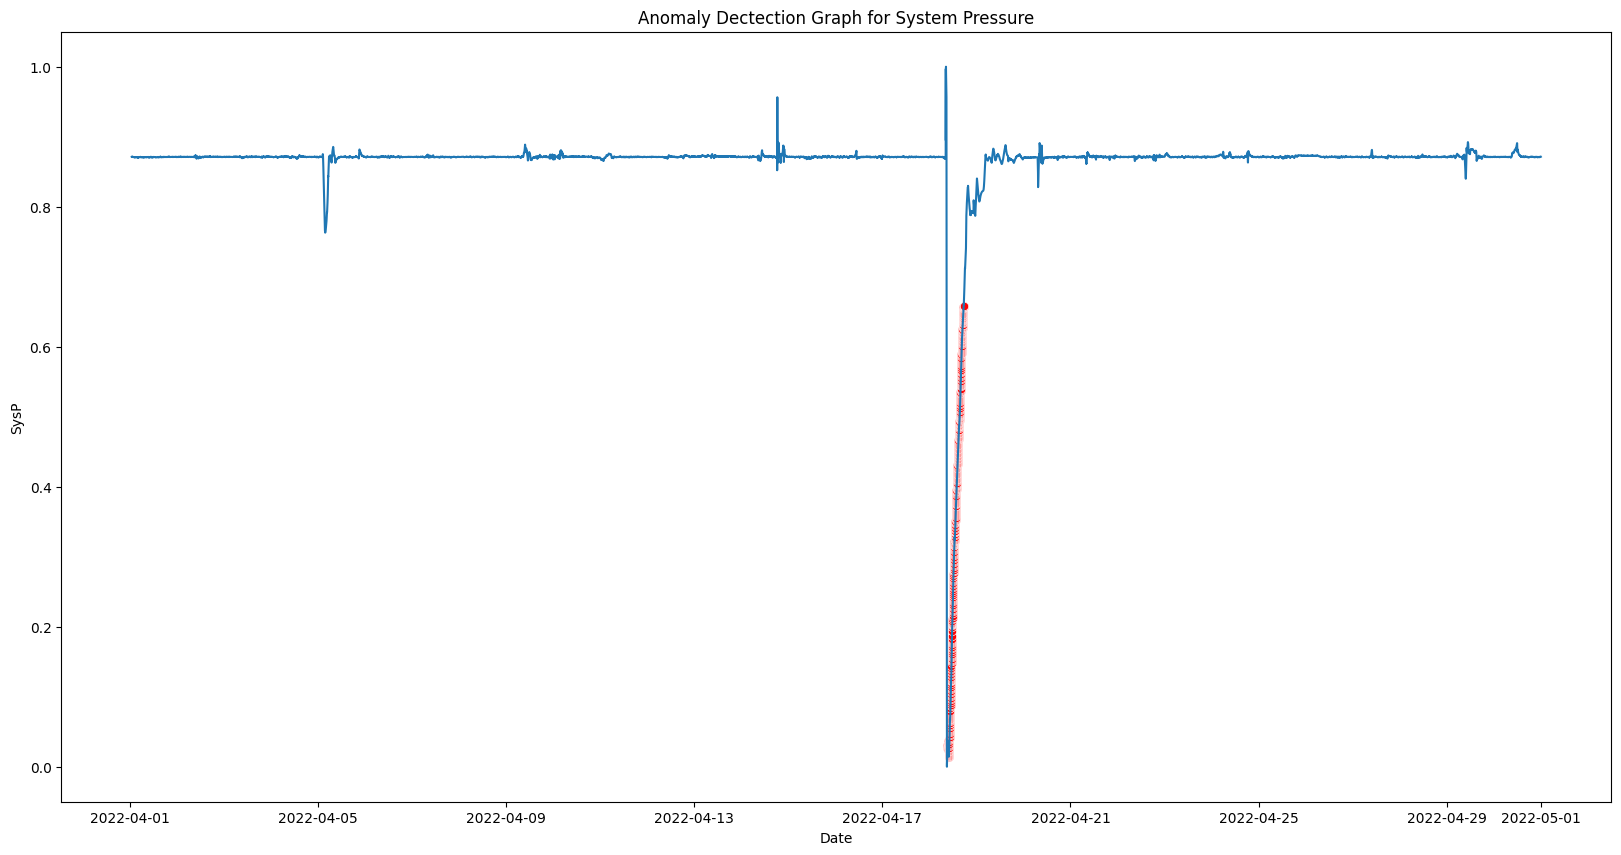

In [20]:
#system pressure
dfanomalyP=pd.DataFrame(dfaP[seq_size:])
dfanomalyP['Atest_MAE']=maeaP
dfanomalyP['max_MAE']=np.mean(maeaP)*3
dfanomalyP['anomaly']=dfanomalyP['Atest_MAE']>dfanomalyP['max_MAE']
dfanomalyP['SysP']=dfaP[seq_size:]['SysP']

anomaliesP=dfanomalyP.loc[dfanomalyP['anomaly']==True]

plt.figure(figsize=(20,10))

#plot anomalies and current data
sns.lineplot(x=dfanomalyP['Date'],y=dfanomalyP['SysP'])
sns.scatterplot(x=dfanomalyP['Date'],y=anomaliesP['SysP'],color='r')

plt.title('Anomaly Dectection Graph for System Pressure')

Text(0.5, 1.0, 'Anomaly Dectection Graph for R-1901 ART')

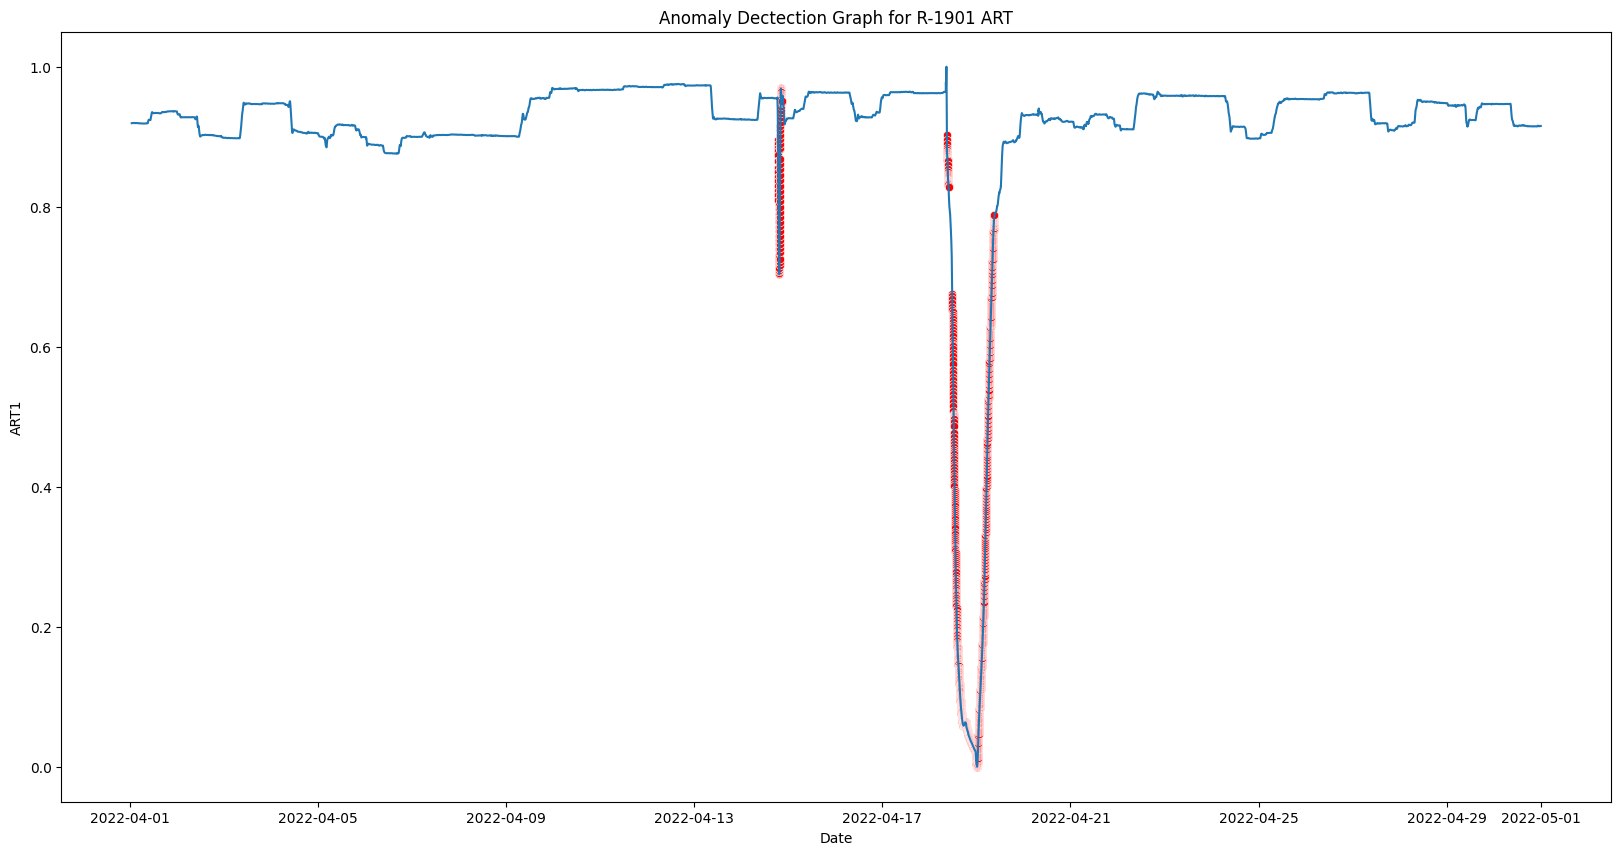

In [21]:
#ART1
dfanomaly1=pd.DataFrame(dfaA1[seq_size:])
dfanomaly1['Atest_MAE']=maea1
dfanomaly1['max_MAE']=np.mean(maea1)*3
dfanomaly1['anomaly']=dfanomaly1['Atest_MAE']>dfanomaly1['max_MAE']
dfanomaly1['ART1']=dfaA1[seq_size:]['ART1']

anomalies1=dfanomaly1.loc[dfanomaly1['anomaly']==True]

plt.figure(figsize=(20,10))

#plot anomalies and current data
sns.lineplot(x=dfanomaly1['Date'],y=dfanomaly1['ART1'])
sns.scatterplot(x=dfanomaly1['Date'],y=anomalies1['ART1'],color='r')

plt.title('Anomaly Dectection Graph for R-1901 ART')

Text(0.5, 1.0, 'Anomaly Dectection Graph for R-1902 ART')

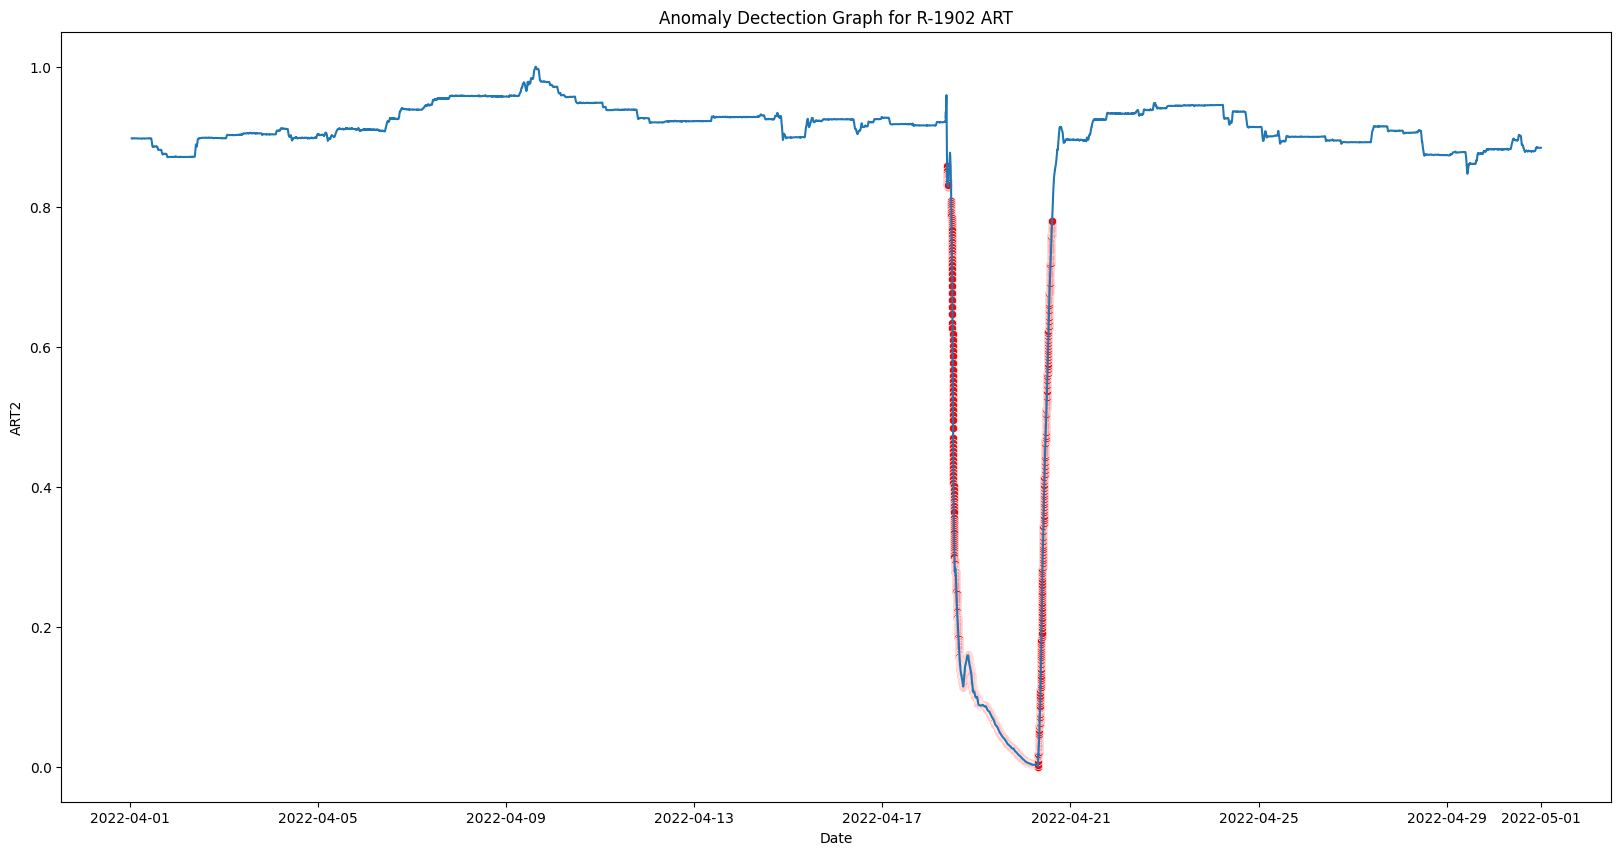

In [22]:
#ART2
dfanomaly2=pd.DataFrame(dfaA2[seq_size:])
dfanomaly2['Atest_MAE']=maea2
dfanomaly2['max_MAE']=np.mean(maea2)*3
dfanomaly2['anomaly']=dfanomaly2['Atest_MAE']>dfanomaly2['max_MAE']
dfanomaly2['ART2']=dfaA2[seq_size:]['ART2']

anomalies2=dfanomaly2.loc[dfanomaly2['anomaly']==True]

plt.figure(figsize=(20,10))

#plot anomalies and current data
sns.lineplot(x=dfanomaly2['Date'],y=dfanomaly2['ART2'])
sns.scatterplot(x=dfanomaly2['Date'],y=anomalies2['ART2'],color='r')

plt.title('Anomaly Dectection Graph for R-1902 ART')

Text(0.5, 1.0, 'Anomaly Dectection Graph for R-1903 ART')

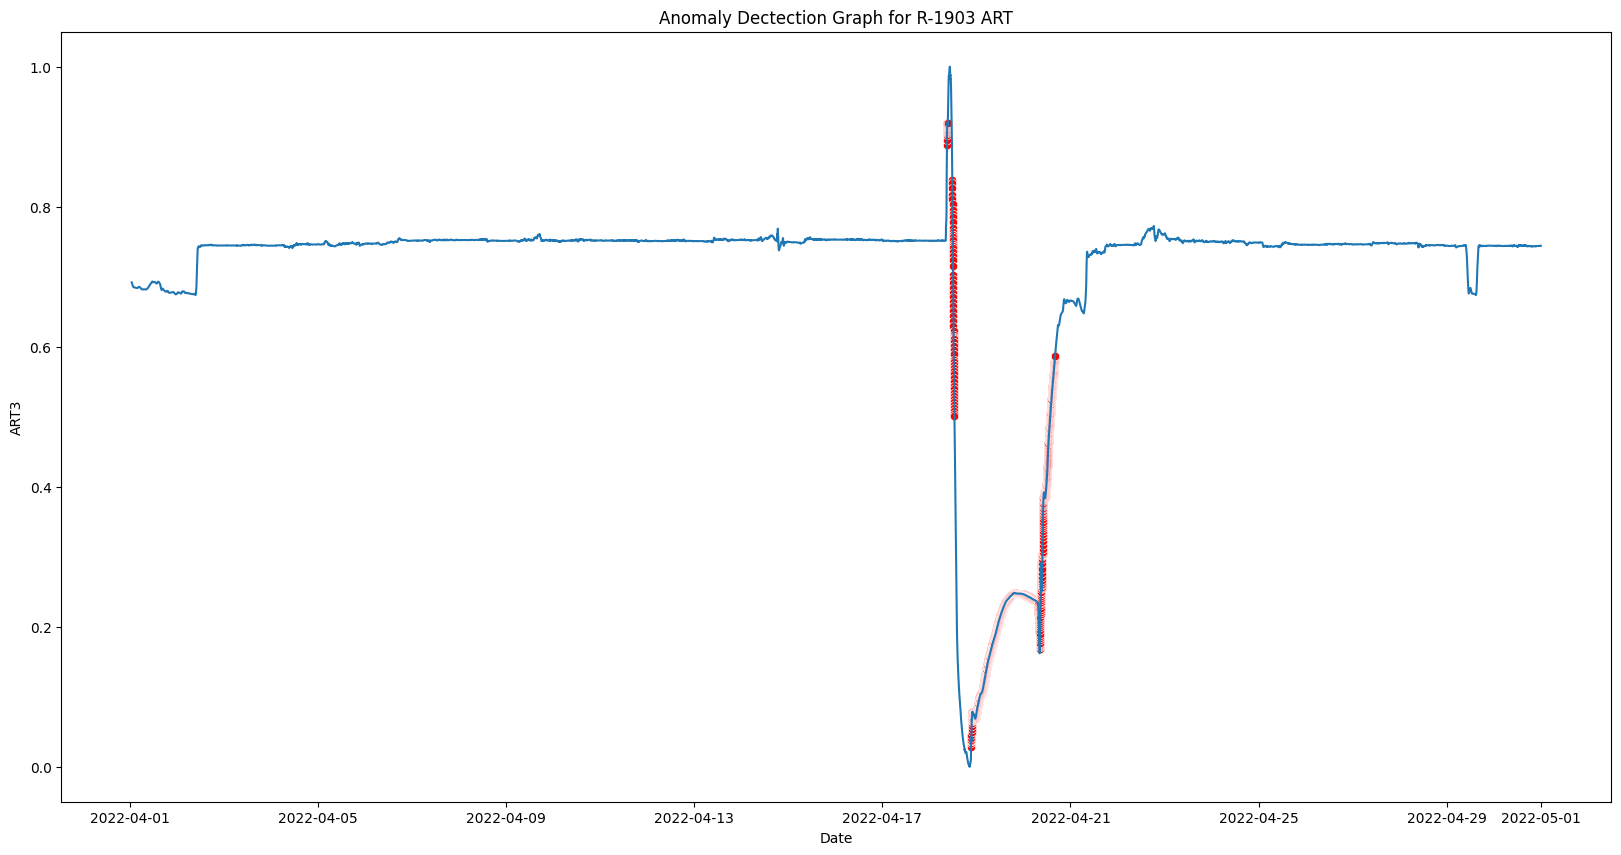

In [23]:
#ART3
dfanomaly3=pd.DataFrame(dfaA3[seq_size:])
dfanomaly3['Atest_MAE']=maea3
dfanomaly3['max_MAE']=np.mean(maea3)*3
dfanomaly3['anomaly']=dfanomaly3['Atest_MAE']>dfanomaly3['max_MAE']
dfanomaly3['ART3']=dfaA3[seq_size:]['ART3']

anomalies3=dfanomaly3.loc[dfanomaly3['anomaly']==True]

plt.figure(figsize=(20,10))

#plot anomalies and current data
sns.lineplot(x=dfanomaly3['Date'],y=dfanomaly3['ART3'])
sns.scatterplot(x=dfanomaly3['Date'],y=anomalies3['ART3'],color='r')

plt.title('Anomaly Dectection Graph for R-1903 ART')

In [24]:
max_mae19=3*np.mean(maea19)
max_mae19

0.020123633157658735

In [25]:
max_maeP=3*np.mean(maeaP)
max_maeP

0.34723352328518664

In [26]:
max_mae1=3*np.mean(maea1)
max_mae1

0.033491192128651426

In [27]:
max_mae2=3*np.mean(maea2)
max_mae2

0.038794541084200954

In [28]:
max_mae3=3*np.mean(maea3)
max_mae3

0.09006448478336357